## San Francisco Crime EDA

In [292]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

In [293]:
df = pd.read_csv('Police_Department_Incident_Reports__Historical_2016_to_May_2018.csv')

In [294]:
dem_df = pd.read_csv('neighborhood_demographics.csv')

In [295]:
dem_df.head()

,geoid,lnnumber,CIT_EST,CIT_MOE,the_geom,NHOOD
0,6075016400,1,3650,324,MULTIPOLYGON (((-122.43246699970955 37.7737570...,Hayes Valley
1,6075016400,2,3340,307,MULTIPOLYGON (((-122.43246699970955 37.7737570...,Hayes Valley
2,6075016400,3,10,13,MULTIPOLYGON (((-122.43246699970955 37.7737570...,Hayes Valley
3,6075016400,4,285,122,MULTIPOLYGON (((-122.43246699970955 37.7737570...,Hayes Valley
4,6075016400,5,450,163,MULTIPOLYGON (((-122.43246699970955 37.7737570...,Hayes Valley


In [296]:
dem_df['NHOOD']

0       Hayes Valley
1       Hayes Valley
2       Hayes Valley
3       Hayes Valley
4       Hayes Valley
            ...     
2530         Mission
2531         Mission
2532         Mission
2533         Mission
2534         Mission
Name: NHOOD, Length: 2535, dtype: object

In [297]:
df.shape

(345979, 14)

In [298]:
# Number of unique addresses
len(list(df['Address'].unique()))

19510

In [299]:
df['Resolution'].unique()

array(['NONE', 'UNFOUNDED', 'ARREST, BOOKED', 'EXCEPTIONAL CLEARANCE',
       'ARREST, CITED', 'PSYCHOPATHIC CASE', 'NOT PROSECUTED', 'LOCATED',
       'COMPLAINANT REFUSES TO PROSECUTE', 'PROSECUTED BY OUTSIDE AGENCY',
       'DISTRICT ATTORNEY REFUSES TO PROSECUTE',
       'PROSECUTED FOR LESSER OFFENSE'], dtype=object)

In [300]:
df['PdDistrict'].unique()

array(['INGLESIDE', 'CENTRAL', 'BAYVIEW', 'SOUTHERN', 'TARAVAL',
       'MISSION', 'TENDERLOIN', 'NORTHERN', 'RICHMOND', 'PARK', nan],
      dtype=object)

In [301]:
(df['Category']).unique()

array(['EMBEZZLEMENT', 'LARCENY/THEFT', 'NON-CRIMINAL',
       'SEX OFFENSES, FORCIBLE', 'ASSAULT', 'SUSPICIOUS OCC', 'TRESPASS',
       'DRUNKENNESS', 'ROBBERY', 'OTHER OFFENSES', 'FRAUD', 'VANDALISM',
       'DRUG/NARCOTIC', 'BURGLARY', 'STOLEN PROPERTY', 'WARRANTS',
       'VEHICLE THEFT', 'MISSING PERSON', 'WEAPON LAWS',
       'RECOVERED VEHICLE', 'ARSON', 'SECONDARY CODES',
       'FORGERY/COUNTERFEITING', 'DISORDERLY CONDUCT',
       'DRIVING UNDER THE INFLUENCE', 'EXTORTION', 'KIDNAPPING',
       'LIQUOR LAWS', 'FAMILY OFFENSES', 'PROSTITUTION', 'BAD CHECKS',
       'SEX OFFENSES, NON FORCIBLE', 'LOITERING',
       'PORNOGRAPHY/OBSCENE MAT', 'SUICIDE', 'BRIBERY', 'GAMBLING',
       'TREA'], dtype=object)

In [302]:
df.head()

,PdId,IncidntNum,Incident Code,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,location
0,16072741510045,160727415,10045,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT BY EMPLOYEE",Friday,01/01/2016,00:01,INGLESIDE,NONE,5700 Block of MISSION ST,-122.450297,37.709552,POINT (-122.45029719777277 37.70955194084215)
1,16600299606372,166002996,6372,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Friday,01/01/2016,13:40,CENTRAL,NONE,JEFFERSON ST / MASON ST,-122.414167,37.808420,POINT (-122.41416651509333 37.808419917270975)
2,17015398506304,170153985,6304,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,Friday,01/01/2016,00:01,BAYVIEW,NONE,100 Block of APOLLO ST,-122.398745,37.730854,POINT (-122.3987447553861 37.730854021807374)
3,16063185010015,160631850,10015,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT",Friday,01/01/2016,12:00,BAYVIEW,NONE,4000 Block of 3RD ST,-122.388753,37.740736,POINT (-122.38875304699722 37.74073605483584)
4,16020260575030,160202605,75030,NON-CRIMINAL,CASE CLOSURE,Friday,01/01/2016,12:00,CENTRAL,UNFOUNDED,2700 Block of HYDE ST,-122.420535,37.806189,POINT (-122.4205346782714 37.8061892244521)


In [303]:
df['Descript'].value_counts()[:457]

GRAND THEFT FROM LOCKED AUTO                     46918
MALICIOUS MISCHIEF, VANDALISM                    11033
PETTY THEFT OF PROPERTY                          10981
LOST PROPERTY                                    10936
AIDED CASE, MENTAL DISTURBED                     10258
                                                 ...  
INDECENT EXPOSURE WITH PRIOR CONVICTION             15
STOLEN CELLULAR PHONE, NON-CLONED, POSSESSION       15
SALE OF COCAINE                                     15
LOITERING                                           15
THEFT, DRUNK ROLL, $200-$400                        15
Name: Descript, Length: 457, dtype: int64

In [304]:
# Making a dataframe of Descriptions that appear at least 50 times in the original dataset
fifty_or_more = pd.DataFrame(df['Descript'].value_counts().index[:457], columns=['Description'])
fifty_or_more.head()

,Description
0,GRAND THEFT FROM LOCKED AUTO
1,"MALICIOUS MISCHIEF, VANDALISM"
2,PETTY THEFT OF PROPERTY
3,LOST PROPERTY
4,"AIDED CASE, MENTAL DISTURBED"


In [305]:
df.groupby(['Descript'])['Resolution'].describe().sort_values(by='count', ascending=False)

,count,unique,top,freq
Descript,,,,
GRAND THEFT FROM LOCKED AUTO,46918,4,NONE,46734
"MALICIOUS MISCHIEF, VANDALISM",11033,4,NONE,10057
PETTY THEFT OF PROPERTY,10981,3,NONE,10840
LOST PROPERTY,10936,5,NONE,10876
"AIDED CASE, MENTAL DISTURBED",10258,8,NONE,9651
...,...,...,...,...
BRIBERY OF WITNESSES,1,1,NONE,1
"INSURED PROPERTY, DESTRUCTION TO DEFRAUD INSURER",1,1,NONE,1
"BURGLARY,WAREHOUSE UNDER CONSTRT, ATT. FORCIBLE",1,1,"ARREST, BOOKED",1


In [306]:
df['Resolution'].value_counts()

NONE                                      255905
ARREST, BOOKED                             86368
UNFOUNDED                                   2790
EXCEPTIONAL CLEARANCE                        595
ARREST, CITED                                208
NOT PROSECUTED                                44
PSYCHOPATHIC CASE                             32
LOCATED                                       29
PROSECUTED FOR LESSER OFFENSE                  3
COMPLAINANT REFUSES TO PROSECUTE               3
PROSECUTED BY OUTSIDE AGENCY                   1
DISTRICT ATTORNEY REFUSES TO PROSECUTE         1
Name: Resolution, dtype: int64

In [307]:
df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = pd.to_datetime(df['Time'])

df.head()

,PdId,IncidntNum,Incident Code,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,location
0,16072741510045,160727415,10045,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT BY EMPLOYEE",Friday,2016-01-01,2020-12-21 00:01:00,INGLESIDE,NONE,5700 Block of MISSION ST,-122.450297,37.709552,POINT (-122.45029719777277 37.70955194084215)
1,16600299606372,166002996,6372,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Friday,2016-01-01,2020-12-21 13:40:00,CENTRAL,NONE,JEFFERSON ST / MASON ST,-122.414167,37.808420,POINT (-122.41416651509333 37.808419917270975)
2,17015398506304,170153985,6304,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,Friday,2016-01-01,2020-12-21 00:01:00,BAYVIEW,NONE,100 Block of APOLLO ST,-122.398745,37.730854,POINT (-122.3987447553861 37.730854021807374)
3,16063185010015,160631850,10015,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT",Friday,2016-01-01,2020-12-21 12:00:00,BAYVIEW,NONE,4000 Block of 3RD ST,-122.388753,37.740736,POINT (-122.38875304699722 37.74073605483584)
4,16020260575030,160202605,75030,NON-CRIMINAL,CASE CLOSURE,Friday,2016-01-01,2020-12-21 12:00:00,CENTRAL,UNFOUNDED,2700 Block of HYDE ST,-122.420535,37.806189,POINT (-122.4205346782714 37.8061892244521)


In [308]:
# Parts of day split between ranges below:
#     morning = 6am - 11:59pm (6,11)
#     aftrenoon = 12pm - 5:59pm (12, 17)
#     evening = 6pm - 10:59pm (18, 22)
#     overnight = 11pm - 5:59am (0, 5)

df['Morning'] = df['Time'].dt.hour.between(6, 11).astype(int)
df['Afternoon'] = df['Time'].dt.hour.between(12, 17).astype(int)
df['Evening'] = df['Time'].dt.hour.between(18, 22).astype(int)
df['Overnight'] = (
    (df['Time'].dt.hour == 23) | \
    (df['Time'].dt.hour.between(0, 5)) \
    ).astype(int)

In [309]:
df['Morning'].value_counts()

0    275051
1     70928
Name: Morning, dtype: int64

In [310]:
df.head()

,PdId,IncidntNum,Incident Code,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,location,Morning,Afternoon,Evening,Overnight
0,16072741510045,160727415,10045,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT BY EMPLOYEE",Friday,2016-01-01,2020-12-21 00:01:00,INGLESIDE,NONE,5700 Block of MISSION ST,-122.450297,37.709552,POINT (-122.45029719777277 37.70955194084215),0,0,0,1
1,16600299606372,166002996,6372,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Friday,2016-01-01,2020-12-21 13:40:00,CENTRAL,NONE,JEFFERSON ST / MASON ST,-122.414167,37.808420,POINT (-122.41416651509333 37.808419917270975),0,1,0,0
2,17015398506304,170153985,6304,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,Friday,2016-01-01,2020-12-21 00:01:00,BAYVIEW,NONE,100 Block of APOLLO ST,-122.398745,37.730854,POINT (-122.3987447553861 37.730854021807374),0,0,0,1
3,16063185010015,160631850,10015,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT",Friday,2016-01-01,2020-12-21 12:00:00,BAYVIEW,NONE,4000 Block of 3RD ST,-122.388753,37.740736,POINT (-122.38875304699722 37.74073605483584),0,1,0,0
4,16020260575030,160202605,75030,NON-CRIMINAL,CASE CLOSURE,Friday,2016-01-01,2020-12-21 12:00:00,CENTRAL,UNFOUNDED,2700 Block of HYDE ST,-122.420535,37.806189,POINT (-122.4205346782714 37.8061892244521),0,1,0,0


In [311]:
df = df.drop(columns=['PdId', 'IncidntNum', 'Incident Code', 'Address', 'location'])
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Year'] = df['Date'].dt.year
df['Time'] = pd.to_datetime(df['Time'])
df['Hour'] = df['Time'].dt.hour

In [312]:
df.head()

,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,X,Y,Morning,Afternoon,Evening,Overnight,Month,Day,Year,Hour
0,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT BY EMPLOYEE",Friday,2016-01-01,2020-12-21 00:01:00,INGLESIDE,NONE,-122.450297,37.709552,0,0,0,1,1,1,2016,0
1,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Friday,2016-01-01,2020-12-21 13:40:00,CENTRAL,NONE,-122.414167,37.808420,0,1,0,0,1,1,2016,13
2,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,Friday,2016-01-01,2020-12-21 00:01:00,BAYVIEW,NONE,-122.398745,37.730854,0,0,0,1,1,1,2016,0
3,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT",Friday,2016-01-01,2020-12-21 12:00:00,BAYVIEW,NONE,-122.388753,37.740736,0,1,0,0,1,1,2016,12
4,NON-CRIMINAL,CASE CLOSURE,Friday,2016-01-01,2020-12-21 12:00:00,CENTRAL,UNFOUNDED,-122.420535,37.806189,0,1,0,0,1,1,2016,12


In [313]:
# These are counts for the most common descriptions that correspond to 'Psychopathic Case' resolution. It's one count
# per row... I can't figure out how to make it one column but you get the idea
df[df['Resolution'] == 'PSYCHOPATHIC CASE'].groupby(['Descript']).count().sort_values(by='Year', ascending=False)[:20]

,Category,DayOfWeek,Date,Time,PdDistrict,Resolution,X,Y,Morning,Afternoon,Evening,Overnight,Month,Day,Year,Hour
Descript,,,,,,,,,,,,,,,,
"AIDED CASE, MENTAL DISTURBED",19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19
TARASOFF REPORT,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
MISSING ADULT,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
AIDED CASE,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
BATTERY,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
FOUND PERSON,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
"RESISTING PEACE OFFICER, CAUSING THEIR SERIOUS INJURY OR DEATH",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
SUSPICIOUS OCCURRENCE,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
UNUSUAL OCCURENCE,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [314]:
df.head()

,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,X,Y,Morning,Afternoon,Evening,Overnight,Month,Day,Year,Hour
0,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT BY EMPLOYEE",Friday,2016-01-01,2020-12-21 00:01:00,INGLESIDE,NONE,-122.450297,37.709552,0,0,0,1,1,1,2016,0
1,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Friday,2016-01-01,2020-12-21 13:40:00,CENTRAL,NONE,-122.414167,37.808420,0,1,0,0,1,1,2016,13
2,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,Friday,2016-01-01,2020-12-21 00:01:00,BAYVIEW,NONE,-122.398745,37.730854,0,0,0,1,1,1,2016,0
3,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT",Friday,2016-01-01,2020-12-21 12:00:00,BAYVIEW,NONE,-122.388753,37.740736,0,1,0,0,1,1,2016,12
4,NON-CRIMINAL,CASE CLOSURE,Friday,2016-01-01,2020-12-21 12:00:00,CENTRAL,UNFOUNDED,-122.420535,37.806189,0,1,0,0,1,1,2016,12


In [315]:
target = {
    'theft': ['LARCENY/THEFT', 'VEHICLE THEFT', 'BURGLARY', 'RECOVERED VEHICLE', 'STOLEN PROPERTY'],
    'other': ['NON-CRIMINAL', 'SUSPICIOUS OCC', 'VANDALISM', 'OTHER OFFENSES', 'SECONDARY CODES',
               'PROSTITUTION', 'SUICIDE', 'FAMILY OFFENSES', 'MISSING PERSON', 'PORNOGRAPHY/OBSCENE MAT'],
    'money': ['FRAUD', 'EMBEZZLEMENT', 'BRIBERY', 'EXTORTION', 'GAMBLING', 'BAD CHECKS', 'FORGERY/COUNTERFEITING'],
    'violent': ['SEX OFFENSES, FORCIBLE', 'ASSAULT', 'ROBBERY', 'SEX OFFENSES, NON FORCIBLE',
                 'KIDNAPPING',  'ARSON', 'WEAPON LAWS'],
    'nonviolent': ['LOITERING', 'DISORDERLY CONDUCT', 'WARRANTS', 'DRUNKENNESS', 'TRESPASS', 'LIQUOR LAWS',
                    'DRUG/NARCOTIC', 'DRIVING UNDER THE INFLUENCE']
}
# The code below was taken from user ALollz's response to question at the following link:
# https://stackoverflow.com/questions/64320960/pandas-create-a-column-by-mapping-from-a-dict-of-lists
target_map = {val:key for key, lst in target.items() for val in lst}
df['Target'] = df['Category'].map(target_map)

In [316]:
target_counts = []
for i in df['Target'].value_counts():
    target_counts.append(i)

In [317]:
target_counts

[132342, 130601, 46483, 28437, 8112]

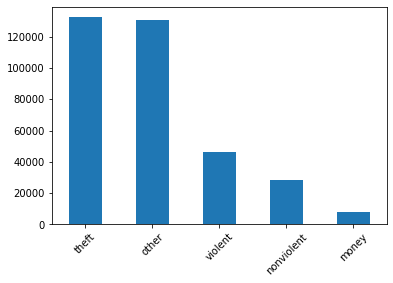

In [318]:
df['Target'].value_counts().plot(kind='bar')
plt.xticks(rotation=45);

In [319]:
df['Target'].unique()

array(['money', 'theft', 'other', 'violent', 'nonviolent', nan],
      dtype=object)

In [320]:
df.dropna(inplace=True)

In [321]:
X = df['Descript']

In [322]:
# This function cleans up text in preparation for NLP

def drop_noise(column):
    clean = []
    for text in column:
        # Make text lower case
        text = text.lower()
        
        # Remove digits
        text = re.sub(r'\d', '', text)
        
        # Remove text enclosed by brackets
        text = re.sub('\[.*?\]', '', text)
        
        # Keep text containing letters A-z
        tokenizer = RegexpTokenizer(r'[A-z]+')
        text = ' '.join(tokenizer.tokenize(text))
        
        clean.append(str(text))
        
    return clean

In [323]:
X_clean = drop_noise(X)

In [324]:
y = df['Target']

In [325]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, random_state=42, stratify=y)

In [326]:
cvec = CountVectorizer(min_df=5, stop_words='english')
X_train_cvec = cvec.fit_transform(X_train)

In [327]:
X_train_cvec.shape

(259480, 607)

In [328]:
X_train_cvec = pd.DataFrame(X_train_cvec.todense(), 
                          columns=cvec.get_feature_names())

In [329]:
X_train_cvec.head()

,abandonment,abuse,access,accessing,accident,accidental,act,activities,activity,acts,...,warehouse,warning,warrant,weapon,wearing,willful,windows,witness,written,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


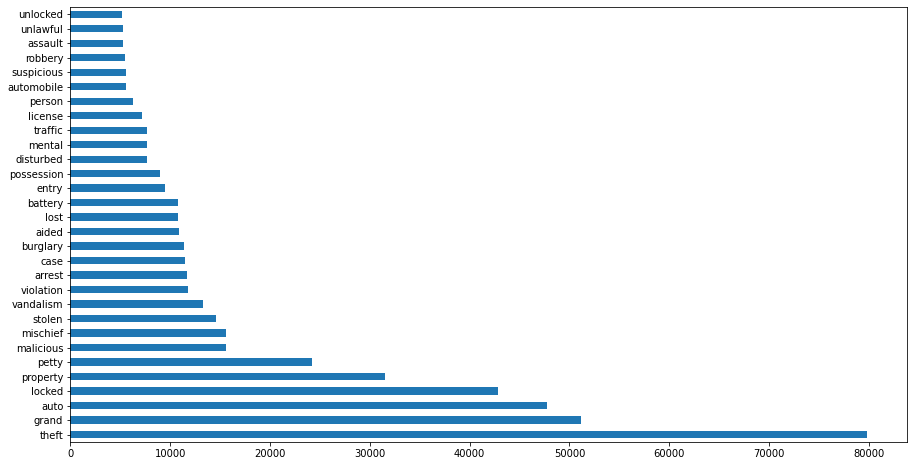

In [330]:
# Plotting most common words from DataFrame
plt.figure(figsize=(15,8))
X_train_cvec.sum().sort_values(ascending=False).head(30).plot(kind='barh');

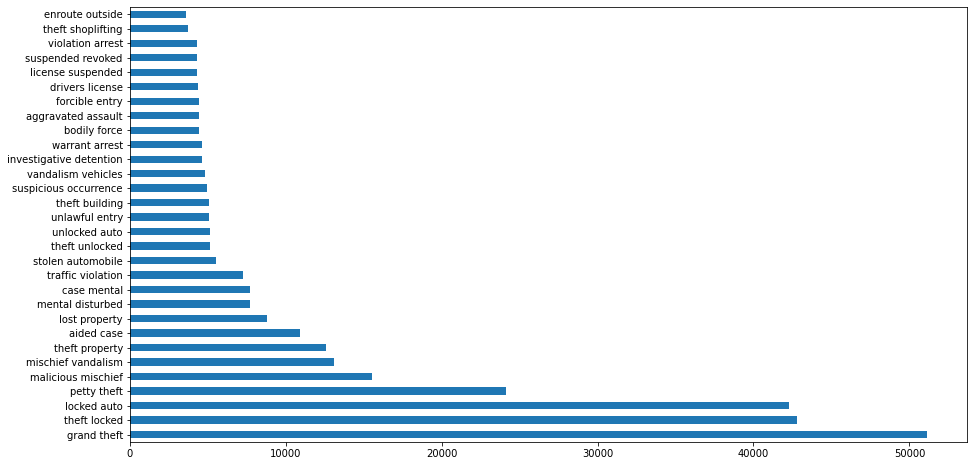

In [331]:
cv_bigrams = CountVectorizer(ngram_range=(2, 2), stop_words='english', min_df=5)
cv_bigrams.fit(X_train)

bigrams_cv = cv_bigrams.transform(X_train)
bigrams_df = pd.DataFrame(bigrams_cv.todense(),
                          columns=cv_bigrams.get_feature_names())

plt.figure(figsize=(15,8))

bigrams_df.sum().sort_values(ascending=False).head(30).plot(kind = 'barh');

Use countvectorizer on descript text to predict in which district a crime will likely happen?

The phrases 'case mental' and 'mental disturbed' occur over 25,000 times --> AIDED CASE, MENTAL DISTURBED

In [332]:
df.head()

,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,X,Y,Morning,Afternoon,Evening,Overnight,Month,Day,Year,Hour,Target
0,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT BY EMPLOYEE",Friday,2016-01-01,2020-12-21 00:01:00,INGLESIDE,NONE,-122.450297,37.709552,0,0,0,1,1,1,2016,0,money
1,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Friday,2016-01-01,2020-12-21 13:40:00,CENTRAL,NONE,-122.414167,37.808420,0,1,0,0,1,1,2016,13,theft
2,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,Friday,2016-01-01,2020-12-21 00:01:00,BAYVIEW,NONE,-122.398745,37.730854,0,0,0,1,1,1,2016,0,theft
3,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT",Friday,2016-01-01,2020-12-21 12:00:00,BAYVIEW,NONE,-122.388753,37.740736,0,1,0,0,1,1,2016,12,money
4,NON-CRIMINAL,CASE CLOSURE,Friday,2016-01-01,2020-12-21 12:00:00,CENTRAL,UNFOUNDED,-122.420535,37.806189,0,1,0,0,1,1,2016,12,other


In [333]:
df[df['Descript'] == "AIDED CASE, MENTAL DISTURBED"].groupby(['Resolution']).count().sort_values(by='Month', ascending=False)[:10]

,Category,Descript,DayOfWeek,Date,Time,PdDistrict,X,Y,Morning,Afternoon,Evening,Overnight,Month,Day,Year,Hour,Target
Resolution,,,,,,,,,,,,,,,,,
NONE,9651,9651,9651,9651,9651,9651,9651,9651,9651,9651,9651,9651,9651,9651,9651,9651,9651
"ARREST, BOOKED",405,405,405,405,405,405,405,405,405,405,405,405,405,405,405,405,405
UNFOUNDED,89,89,89,89,89,89,89,89,89,89,89,89,89,89,89,89,89
EXCEPTIONAL CLEARANCE,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86
PSYCHOPATHIC CASE,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19
NOT PROSECUTED,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
LOCATED,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
PROSECUTED BY OUTSIDE AGENCY,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [334]:
# 20 most common descriptions when the resolution contains the word JUVENILE
df[df['Resolution'].str.contains('JUVENILE')].groupby(['Descript']).count().sort_values(by='Month', ascending=False)[:20]

,Category,DayOfWeek,Date,Time,PdDistrict,Resolution,X,Y,Morning,Afternoon,Evening,Overnight,Month,Day,Year,Hour,Target
Descript,,,,,,,,,,,,,,,,,


In [335]:
target_counts = []
for i in df['Target'].value_counts():
    target_counts.append(i)

In [336]:
target_counts

[132341, 130601, 46483, 28437, 8112]

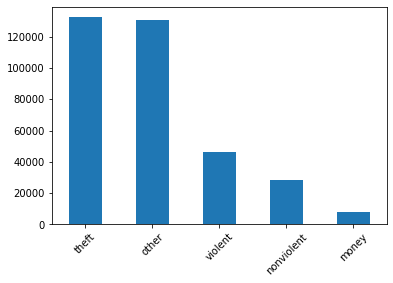

In [337]:
df['Target'].value_counts().plot(kind='bar')
plt.xticks(rotation=45);

In [338]:
df['Target'].unique()

array(['money', 'theft', 'other', 'violent', 'nonviolent'], dtype=object)

In [339]:
df.head()

,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,X,Y,Morning,Afternoon,Evening,Overnight,Month,Day,Year,Hour,Target
0,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT BY EMPLOYEE",Friday,2016-01-01,2020-12-21 00:01:00,INGLESIDE,NONE,-122.450297,37.709552,0,0,0,1,1,1,2016,0,money
1,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Friday,2016-01-01,2020-12-21 13:40:00,CENTRAL,NONE,-122.414167,37.808420,0,1,0,0,1,1,2016,13,theft
2,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,Friday,2016-01-01,2020-12-21 00:01:00,BAYVIEW,NONE,-122.398745,37.730854,0,0,0,1,1,1,2016,0,theft
3,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT",Friday,2016-01-01,2020-12-21 12:00:00,BAYVIEW,NONE,-122.388753,37.740736,0,1,0,0,1,1,2016,12,money
4,NON-CRIMINAL,CASE CLOSURE,Friday,2016-01-01,2020-12-21 12:00:00,CENTRAL,UNFOUNDED,-122.420535,37.806189,0,1,0,0,1,1,2016,12,other


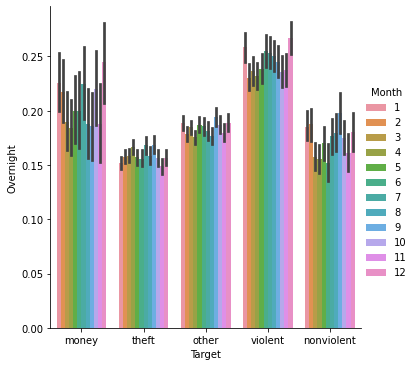

In [340]:
sns.catplot(x="Target", y="Overnight", hue="Month", kind="bar", data=df);

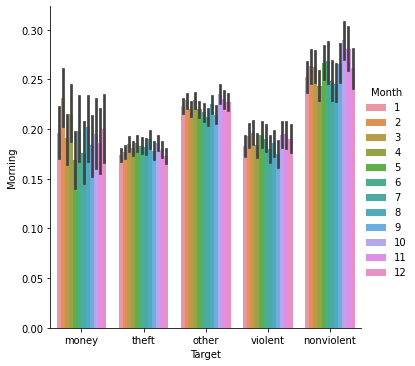

In [341]:
sns.catplot(x="Target", y="Morning", hue="Month", kind="bar", data=df);

<Figure size 1080x1440 with 0 Axes>

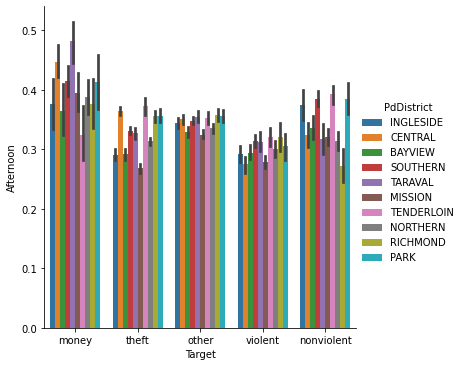

In [342]:
plt.figure(figsize=(15, 20))
sns.catplot(x="Target", y="Afternoon", hue="PdDistrict", kind="bar", data=df);

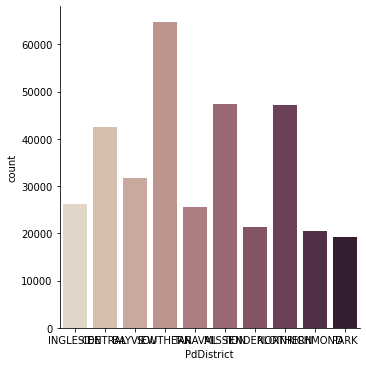

In [343]:
sns.catplot(x="PdDistrict", kind="count", palette="ch:.25", data=df, legend_out=True);

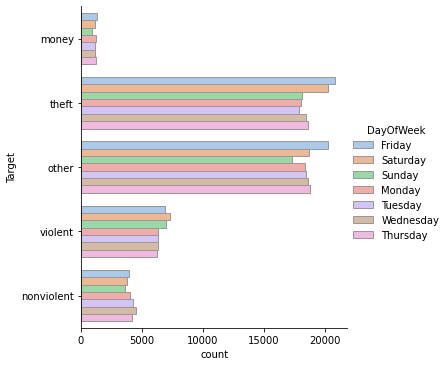

In [344]:
sns.catplot(y="Target", hue="DayOfWeek", kind="count",
            palette="pastel", edgecolor=".6",
            data=df);

In [353]:
df.head()

,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,X,Y,Morning,Afternoon,Evening,Overnight,Month,Day,Year,Hour,Target
0,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT BY EMPLOYEE",Friday,2016-01-01,2020-12-21 00:01:00,INGLESIDE,NONE,-122.450297,37.709552,0,0,0,1,1,1,2016,0,money
1,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Friday,2016-01-01,2020-12-21 13:40:00,CENTRAL,NONE,-122.414167,37.808420,0,1,0,0,1,1,2016,13,theft
2,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,Friday,2016-01-01,2020-12-21 00:01:00,BAYVIEW,NONE,-122.398745,37.730854,0,0,0,1,1,1,2016,0,theft
3,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT",Friday,2016-01-01,2020-12-21 12:00:00,BAYVIEW,NONE,-122.388753,37.740736,0,1,0,0,1,1,2016,12,money
4,NON-CRIMINAL,CASE CLOSURE,Friday,2016-01-01,2020-12-21 12:00:00,CENTRAL,UNFOUNDED,-122.420535,37.806189,0,1,0,0,1,1,2016,12,other


/Users/gcano01/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


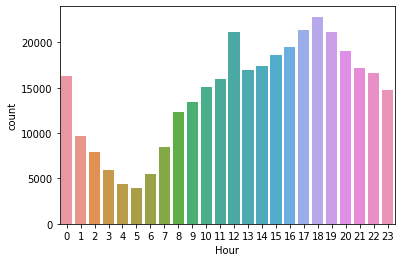

In [358]:
sns.countplot(df['Hour']);

/Users/gcano01/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


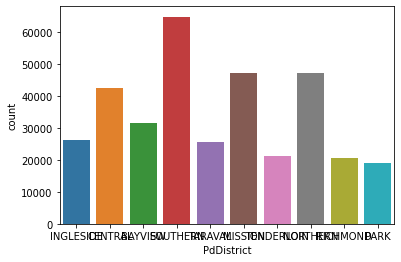

In [359]:
plt.figure(figsize=(20, 12))
sns.countplot(df['PdDistrict']);

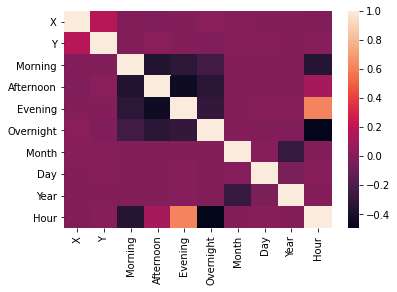

In [362]:
sns.heatmap(df.corr());

In [ ]:
df['PdDistrict'].value_counts()

In [346]:
df.head()

,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,X,Y,Morning,Afternoon,Evening,Overnight,Month,Day,Year,Hour,Target
0,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT BY EMPLOYEE",Friday,2016-01-01,2020-12-21 00:01:00,INGLESIDE,NONE,-122.450297,37.709552,0,0,0,1,1,1,2016,0,money
1,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Friday,2016-01-01,2020-12-21 13:40:00,CENTRAL,NONE,-122.414167,37.808420,0,1,0,0,1,1,2016,13,theft
2,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,Friday,2016-01-01,2020-12-21 00:01:00,BAYVIEW,NONE,-122.398745,37.730854,0,0,0,1,1,1,2016,0,theft
3,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT",Friday,2016-01-01,2020-12-21 12:00:00,BAYVIEW,NONE,-122.388753,37.740736,0,1,0,0,1,1,2016,12,money
4,NON-CRIMINAL,CASE CLOSURE,Friday,2016-01-01,2020-12-21 12:00:00,CENTRAL,UNFOUNDED,-122.420535,37.806189,0,1,0,0,1,1,2016,12,other


Brainstorming

- What is our target? PDistrict or Category?

- Classify X and Y columns as neighborhoods

- NLP on description

- Juvenile Cases --> where are they happening and when? Can we predict at what time of day juveniles will be out and about causing mischief?

- When resolution is 'Psychopathic Case', the top corresponding categories are: non-criminal (13486), missing person (216), assault (214), and suicide (103). Can we predict where non-criminal cases are happening, so we can send fewer cops there? The top corresponding descript by far is 'Aided Case, Mental Disturbed' (12,917)